# Forecasting with Dynamic Linear Model (DLM)

Among state space models, Dynamic Linear Model (DLM) are one of the most popular models due to its explainability and ability to incorporate regressors with dynamic coefficients. This notebook introduces a way to construct a vanlia DLM through Pyro and Forecaster modules. In the end, it provides an extension to coefficients priors incorporation.

See also:
- [Forecasting II: state space models](http://pyro.ai/examples/forecasting_ii.html)

#### Workflow 
1. data simulation
2. visualization of coefficients and response
3. Standard DLM training and validation
    - posteriors comparison
    - holdout validation
4. DLM with coefficients priors at various time points
    - posteriors comparison
    - holdout validation

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.forecast import ForecastingModel, Forecaster, backtest, eval_crps
from pyro.infer.autoguide import AutoLowRankMultivariateNormal
from pyro.infer.reparam import LocScaleReparam, StableReparam, HaarReparam
from pyro.ops.stats import quantile

%matplotlib inline
assert pyro.__version__.startswith('1.4.0')

pyro.enable_validation(True)
pyro.set_rng_seed(20200928)

pd.set_option('display.max_rows', 500)
plt.style.use('fivethirtyeight')

## Data Simulation

Assume we have observation $y_t$ at time $t$ such that 
$$y_t = x_t^T \beta_t + \epsilon_t$$
$$\beta_t = \beta_{t-1} + \delta_t$$
where

$x_t$ is a P x 1 vector of regressors at time $t$

$\beta_t$ is a P x 1 vector of latent coefficients at time $t$ following a random walk distribution

$\epsilon$ is the noise at time $t$

We then simulate data in following distribution:
$$x_t \sim \mathcal{N}_p(0, \sigma_x^2)$$
$$\delta_t \sim \mathcal{N}_p(0, \sigma_{\delta}^2)$$
$$\epsilon_t \sim \mathcal{N}(0, \sigma_y^2)$$

In [2]:
np.random.seed(20200820)
# number of predictors, total observations
p = 5
n = 365 * 3

# start, train end, test end
T0 = 0            
T1 = n - 28
T2 = n

# initializing coefficients at zeros, simulate all coefficient values
beta0 = torch.from_numpy(np.cumsum(np.random.normal(0, 0.3, n))).unsqueeze(-1)
betas_p = torch.from_numpy(np.cumsum(np.random.normal(0, 0.05, size=(n, p)), axis=0))
betas = torch.cat([beta0, betas_p], dim=-1)

# simulate regressors
covariates = torch.cat(
    [torch.ones(n, 1), 0.5 * torch.randn(n, p) * 0.5],
    dim=-1
)

# observation with noise
y = ((covariates * betas).sum(-1) + 0.1 * torch.randn(n)).unsqueeze(-1)

## Visualization of response and coefficients

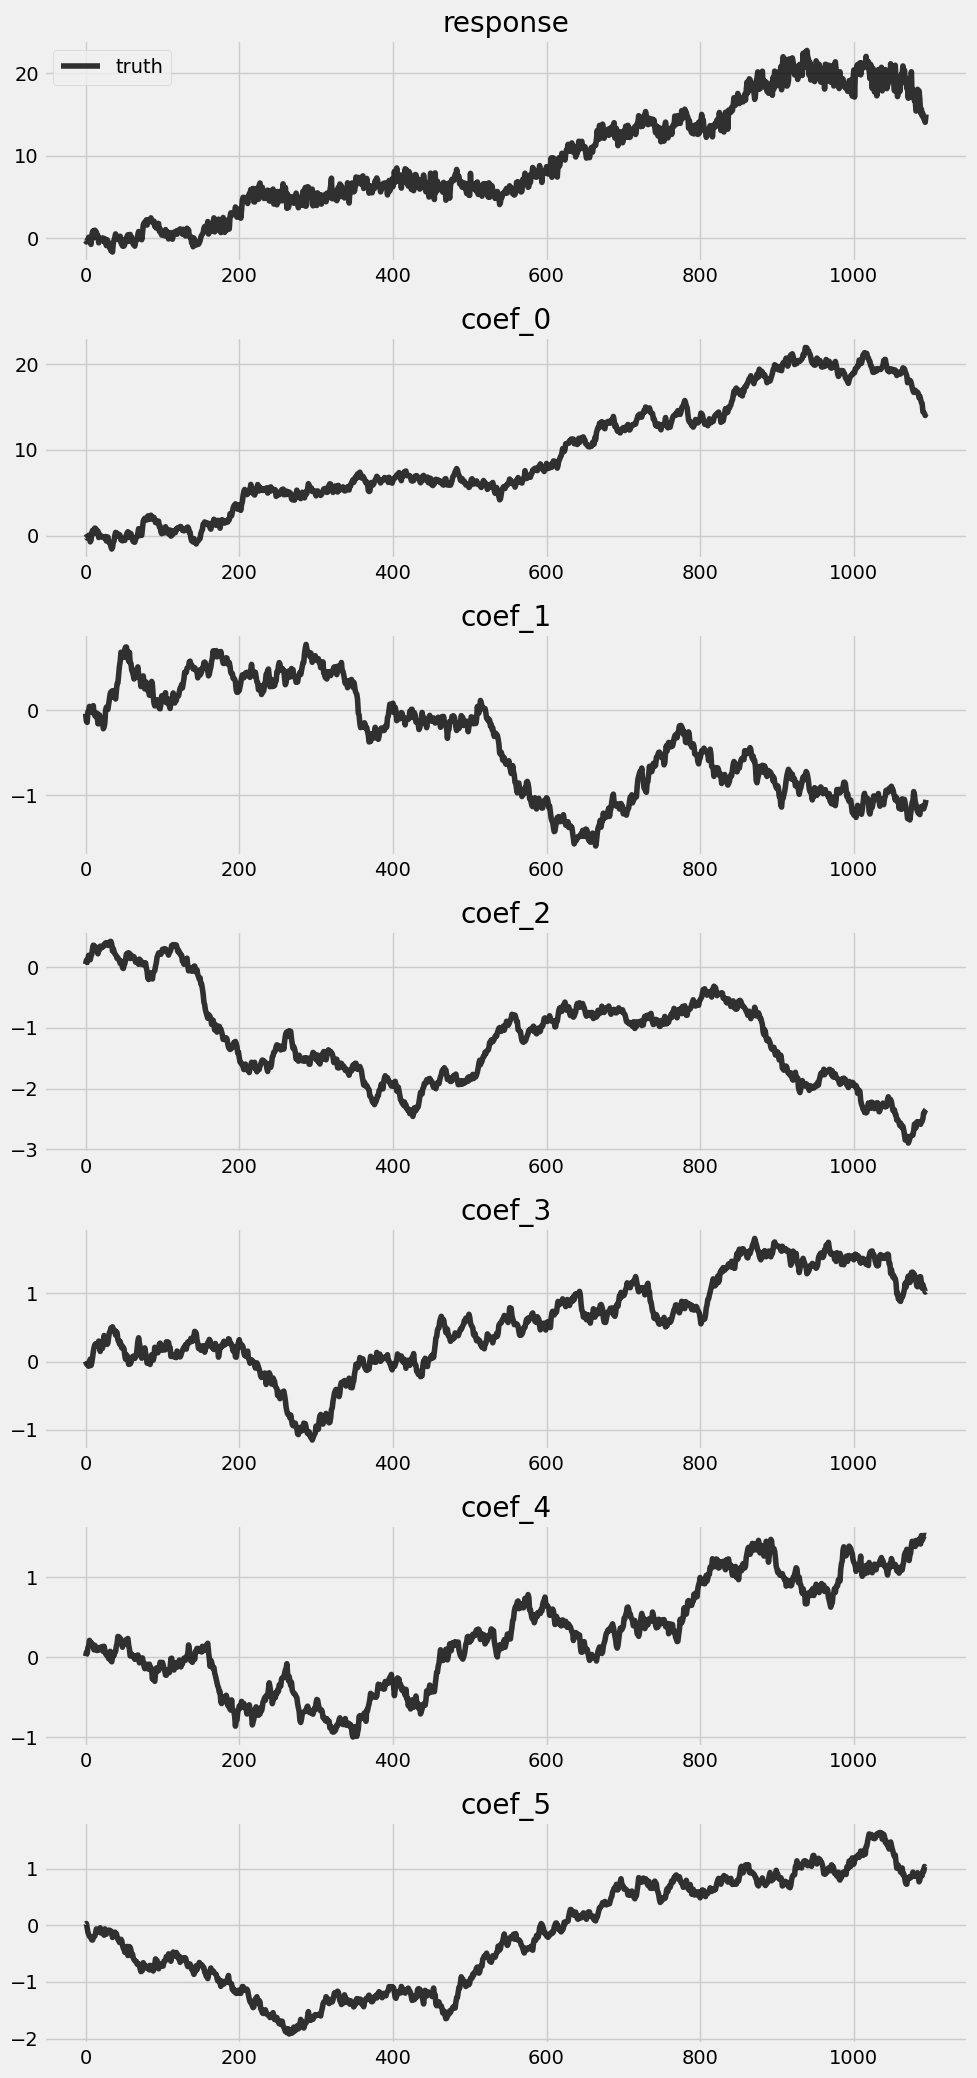

In [3]:
fig, axes = plt.subplots(p + 2, 1, figsize=(10, 3 * (p + 2)))

for idx, ax in enumerate(axes):
    if idx == 0:
        axes[0].plot(y, 'k-', label='truth', alpha=.8)
        axes[0].legend()
        axes[0].set_title('response')
    else:
        axes[idx].plot(betas[:, idx -  1], 'k-', label='truth', alpha=.8)
        axes[idx].set_title('coef_{}'.format(idx - 1))
plt.tight_layout()

## Train and validate a vanlia DLM

In [4]:
class DLM(ForecastingModel):
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)
        
        drift_scale = pyro.sample("drift_scale", dist.LogNormal(-10, 10).expand([feature_dim]).to_event(1))
        with self.time_plate:
            with poutine.reparam(config={"drift": LocScaleReparam()}):
                drift = pyro.sample("drift", dist.Normal(torch.zeros(covariates.size()), drift_scale).to_event(1))
        
        weight = drift.cumsum(-2)  # A Brownian motion.
        # record in model_trace 
        pyro.deterministic("weight", weight) 

        prediction = (weight * covariates).sum(-1, keepdim=True) 
        assert prediction.shape[-2:] == zero_data.shape
        # record in model_trace 
        pyro.deterministic("prediction", prediction)
        
        scale = pyro.sample("noise_scale", dist.LogNormal(-5, 10).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, scale)
        
        self.predict(noise_dist, prediction)      

In [5]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
model = DLM()
forecaster = Forecaster(
    model, 
    y[:T1], 
    covariates[:T1], 
    learning_rate=0.1, 
    learning_rate_decay=0.05, 
    num_steps=2000,
)

INFO 	 step    0 loss = 1.07595e+12
INFO 	 step  100 loss = 339.765
INFO 	 step  200 loss = 3.60537
INFO 	 step  300 loss = 3.12338
INFO 	 step  400 loss = 2.97277
INFO 	 step  500 loss = 2.92852
INFO 	 step  600 loss = 2.30756
INFO 	 step  700 loss = 2.42813
INFO 	 step  800 loss = 2.99653
INFO 	 step  900 loss = 2.38619
INFO 	 step 1000 loss = 2.30481
INFO 	 step 1100 loss = 2.63209
INFO 	 step 1200 loss = 2.39492
INFO 	 step 1300 loss = 2.91822
INFO 	 step 1400 loss = 2.08431
INFO 	 step 1500 loss = 2.66119
INFO 	 step 1600 loss = 2.44612
INFO 	 step 1700 loss = 1.98627
INFO 	 step 1800 loss = 1.89163
INFO 	 step 1900 loss = 2.04551


CPU times: user 13.9 s, sys: 57.8 ms, total: 14 s
Wall time: 14 s


### Posteriors comparison

We extract posteriors during the in-sample period and compare them against the truth.

In [6]:
# record all latent variables in a trace
with poutine.trace() as tr:
    forecaster(y[:T1], covariates[:T1], num_samples=100)

# extract the values from the recorded trace
posterior_samples = {
    name: site["value"]
    for name, site in tr.trace.nodes.items()
    if site["type"] == "sample"
}

In [7]:
forecaster.guide()['drift_scale']

tensor([0.0849, 0.0128, 0.0263, 0.0141, 0.0104, 0.0113],
       grad_fn=<ExpandBackward>)

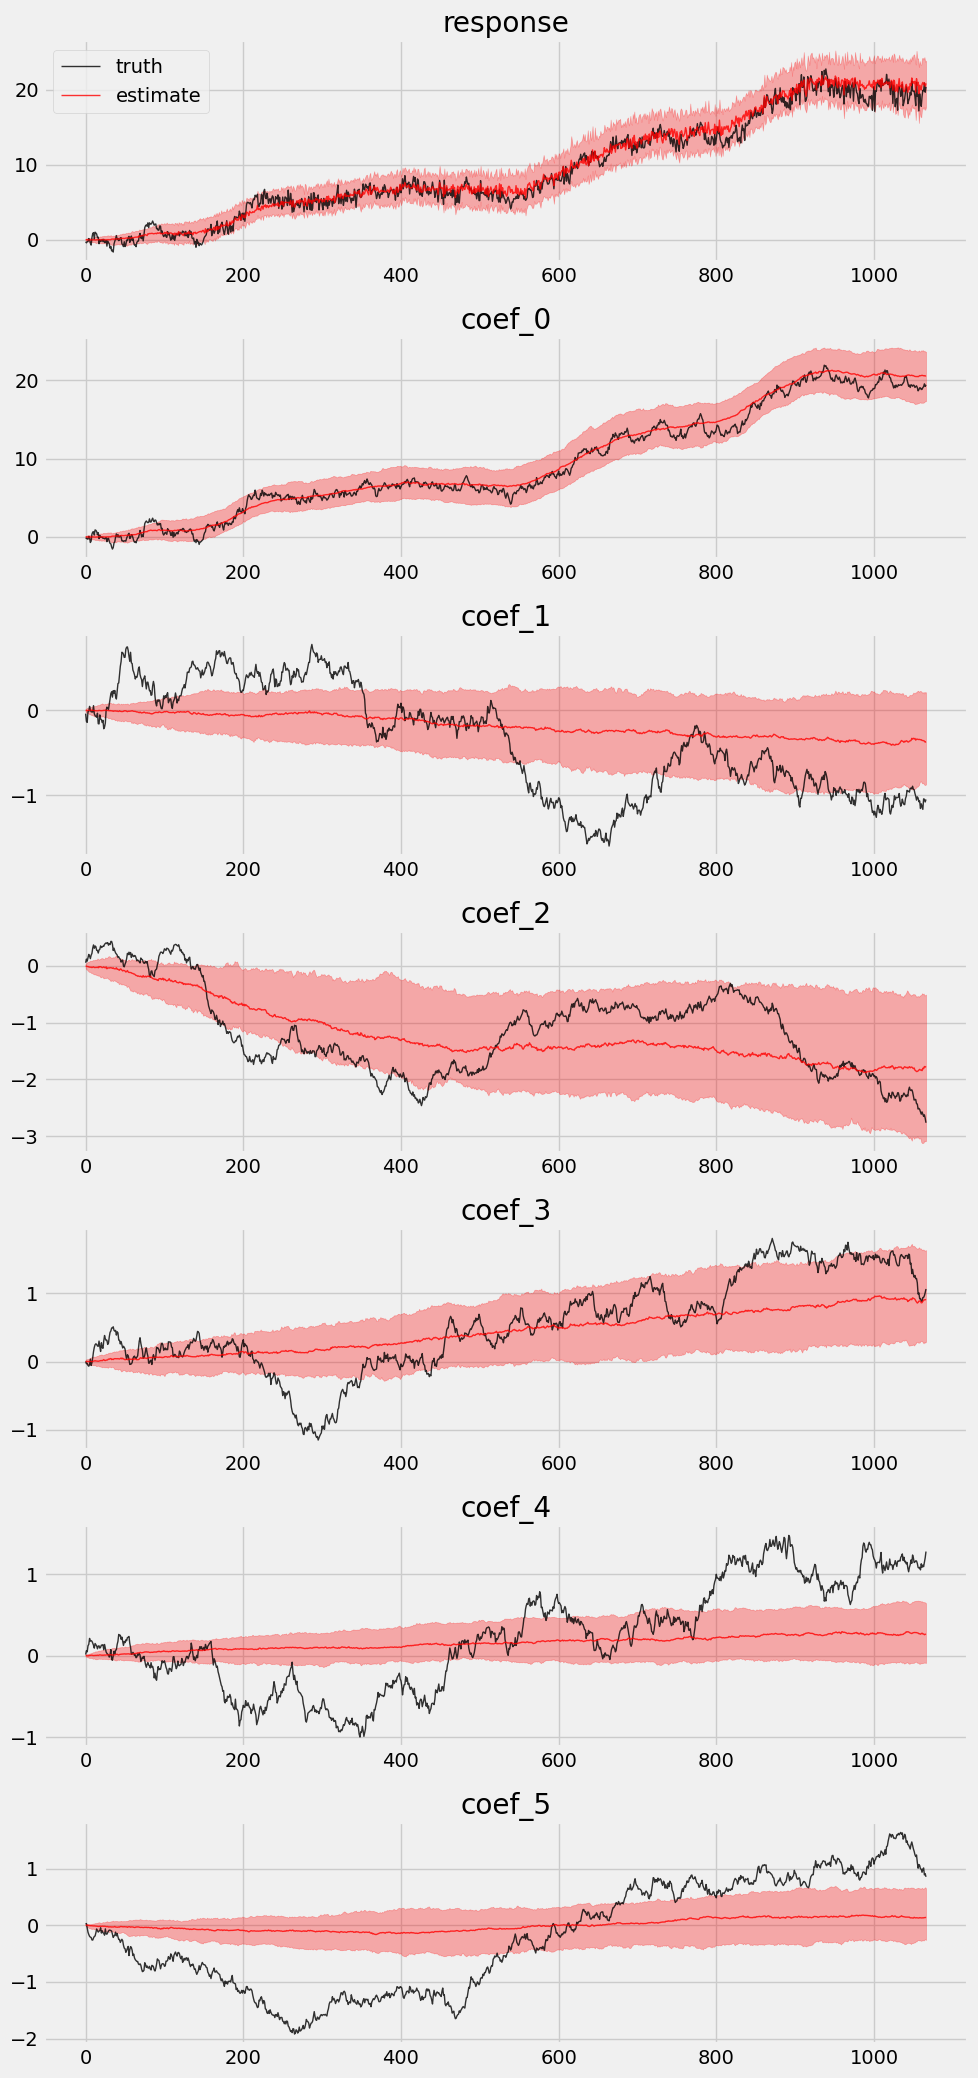

In [8]:
# overlay estimations with truth
fig, axes = plt.subplots(p + 2, 1, figsize=(10, 3 * (p + 2)))
# posterior quantiles of latent variables
pred_p10, pred_p50, pred_p90 = quantile(posterior_samples['prediction'], (0.1, 0.5, 0.9)).squeeze(-1)
# posterior quantiles of latent variables
coef_p10, coef_p50, coef_p90 = quantile(posterior_samples['weight'], (0.1, 0.5, 0.9)).squeeze(-1)

for idx, ax in enumerate(axes):
    if idx == 0:
        axes[0].plot(y[:T1], 'k-', label='truth', alpha=.8, lw=1)
        axes[0].plot(pred_p50, 'r-', label='estimate', alpha=.8, lw=1)
        axes[0].fill_between(torch.arange(0, T1), pred_p10, pred_p90, color="red", alpha=.3)
        axes[0].legend()
        axes[0].set_title('response')
    else:
        axes[idx].plot(betas[:T1, idx -  1], 'k-', label='truth', alpha=.8, lw=1)
        axes[idx].plot(coef_p50[:, idx - 1], 'r-', label='estimate', alpha=.8, lw=1)
        axes[idx].fill_between(torch.arange(0, T1), coef_p10[:, idx-1], coef_p90[:, idx-1], color="red", alpha=.3)
        axes[idx].set_title('coef_{}'.format(idx - 1))
plt.tight_layout()

We can see that the estimated coefficients are fairly consistent on average.  However, we can improve the estimation if we have informative priors for the coefficients at some time points.

### Holdout validation

torch.Size([1000, 28, 1]) torch.Size([28])


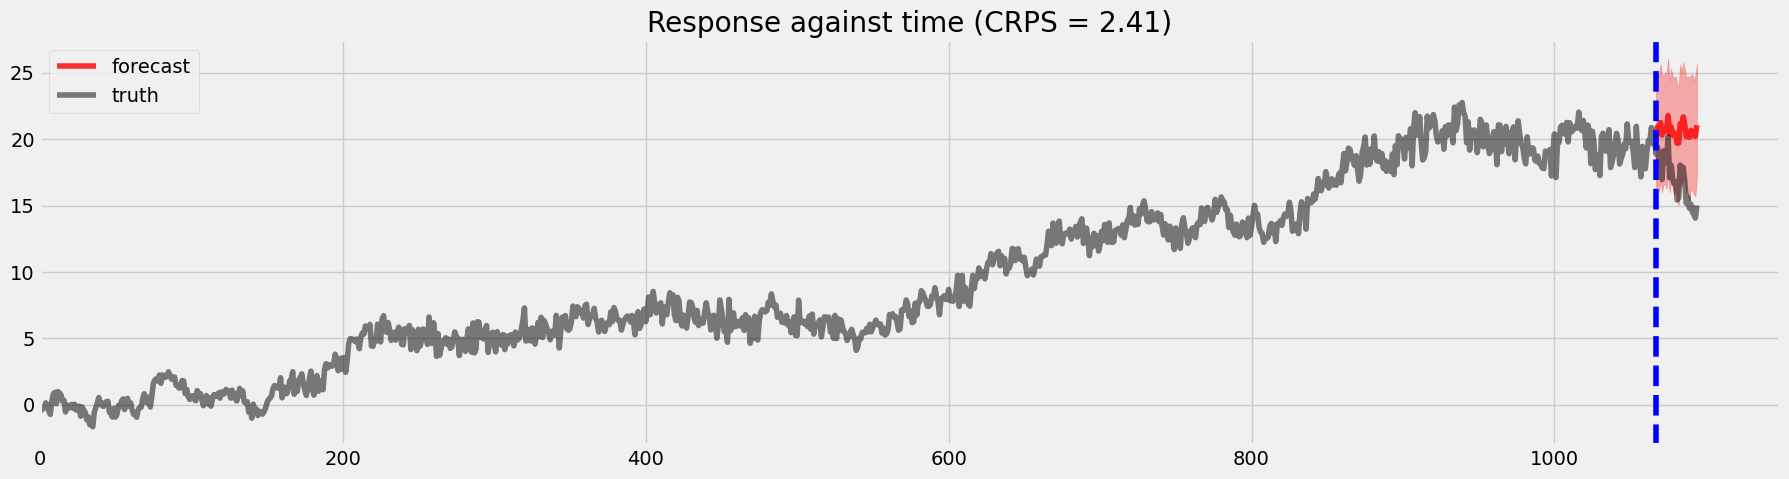

In [9]:
samples = forecaster(y[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, y[T1:])
print(samples.shape, p10.shape)

plt.figure(figsize=(20, 5))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast', alpha=.8)
plt.plot(y, 'k-', label='truth', alpha=.5)
plt.title("Response against time (CRPS = {:0.3g})".format(crps))
plt.xlim(0, None)
plt.axvline(T1, color='b', linestyle='--')
plt.legend(loc="best");

## Train a DLM with coefficients priors at various time points

Sometime user may have prior beliefs of certain coefficients at certain time point. This is especially practical to applications on business where modelers can perform experiments at certain point. In that sense, we should provide an informative prior since experiments usually yield stronger casuality measure. For illustration, we create a simple evenly distributed time points and set priors on those points with the known value $B_t$. Hence, 
$$ \beta_t \sim \mathcal{N}_p(B_t, 0.1)$$ such that $t \in [t_1, t_2, ... t_n]$ and $[t_1, t_2, ... t_n]$ are the time points we have experiential results.

In [10]:
# let's provide some priors
# TODO: provide time points in a set of ranges
time_points = np.concatenate((
    np.arange(150, 160),
    np.arange(300, 320),
    np.arange(450, 460),
    np.arange(700, 720),
    np.arange(850, 860),
))
priors = betas[time_points, 1:]

In [11]:
print(time_points.shape, priors.shape)

(70,) torch.Size([70, 5])


### Model Training

In [12]:
class DLM2(ForecastingModel):
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)

        drift_scale = pyro.sample("drift_scale", dist.LogNormal(-10, 10).expand([feature_dim]).to_event(1))
        with self.time_plate:
            with poutine.reparam(config={"drift": LocScaleReparam()}):
                drift = pyro.sample("drift", dist.Normal(torch.zeros(covariates.size()), drift_scale).to_event(1))
        weight = drift.cumsum(-2)  # A Brownian motion.
        # record in model_trace 
        pyro.deterministic("weight", weight)
        # coef. priors injection 
        for tp, prior in zip(time_points, priors):
            pyro.sample("weight_prior_{}".format(tp), dist.Normal(prior, 1e-1).to_event(1), obs=weight[..., tp:tp+1, 1:]) 

        prediction = (weight * covariates).sum(-1, keepdim=True) 
        assert prediction.shape[-2:] == zero_data.shape
        # record in model_trace 
        pyro.deterministic("prediction", prediction)
        
        scale = pyro.sample("noise_scale", dist.LogNormal(-5, 10).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, scale)
        self.predict(noise_dist, prediction)       

In [13]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
model = DLM2()
forecaster = Forecaster(
    model, 
    y[:T1], 
    covariates[:T1], 
    learning_rate=0.1, 
    learning_rate_decay=0.05, 
    num_steps=2000,
)

INFO 	 step    0 loss = 1.07595e+12
INFO 	 step  100 loss = 119.494
INFO 	 step  200 loss = 5.31537
INFO 	 step  300 loss = 7.39275
INFO 	 step  400 loss = 4.51923
INFO 	 step  500 loss = 3.64493
INFO 	 step  600 loss = 4.7877
INFO 	 step  700 loss = 4.34841
INFO 	 step  800 loss = 4.30238
INFO 	 step  900 loss = 3.4971
INFO 	 step 1000 loss = 3.26836
INFO 	 step 1100 loss = 5.38602
INFO 	 step 1200 loss = 3.96012
INFO 	 step 1300 loss = 3.89632
INFO 	 step 1400 loss = 3.04324
INFO 	 step 1500 loss = 3.33265
INFO 	 step 1600 loss = 2.89039
INFO 	 step 1700 loss = 3.14942
INFO 	 step 1800 loss = 3.27307
INFO 	 step 1900 loss = 3.22925


CPU times: user 1min 4s, sys: 186 ms, total: 1min 4s
Wall time: 1min 4s


### Posterior comparison

In [14]:
# record all latent variables in a trace
with poutine.trace() as tr:
    forecaster(y[:T1], covariates[:T1], num_samples=100)

# extract the values from the recorded trace
posterior_samples = {
    name: site["value"]
    for name, site in tr.trace.nodes.items()
    if site["type"] == "sample"
}

In [15]:
forecaster.guide()['drift_scale']

tensor([0.0717, 0.0084, 0.0111, 0.0108, 0.0084, 0.0087],
       grad_fn=<ExpandBackward>)

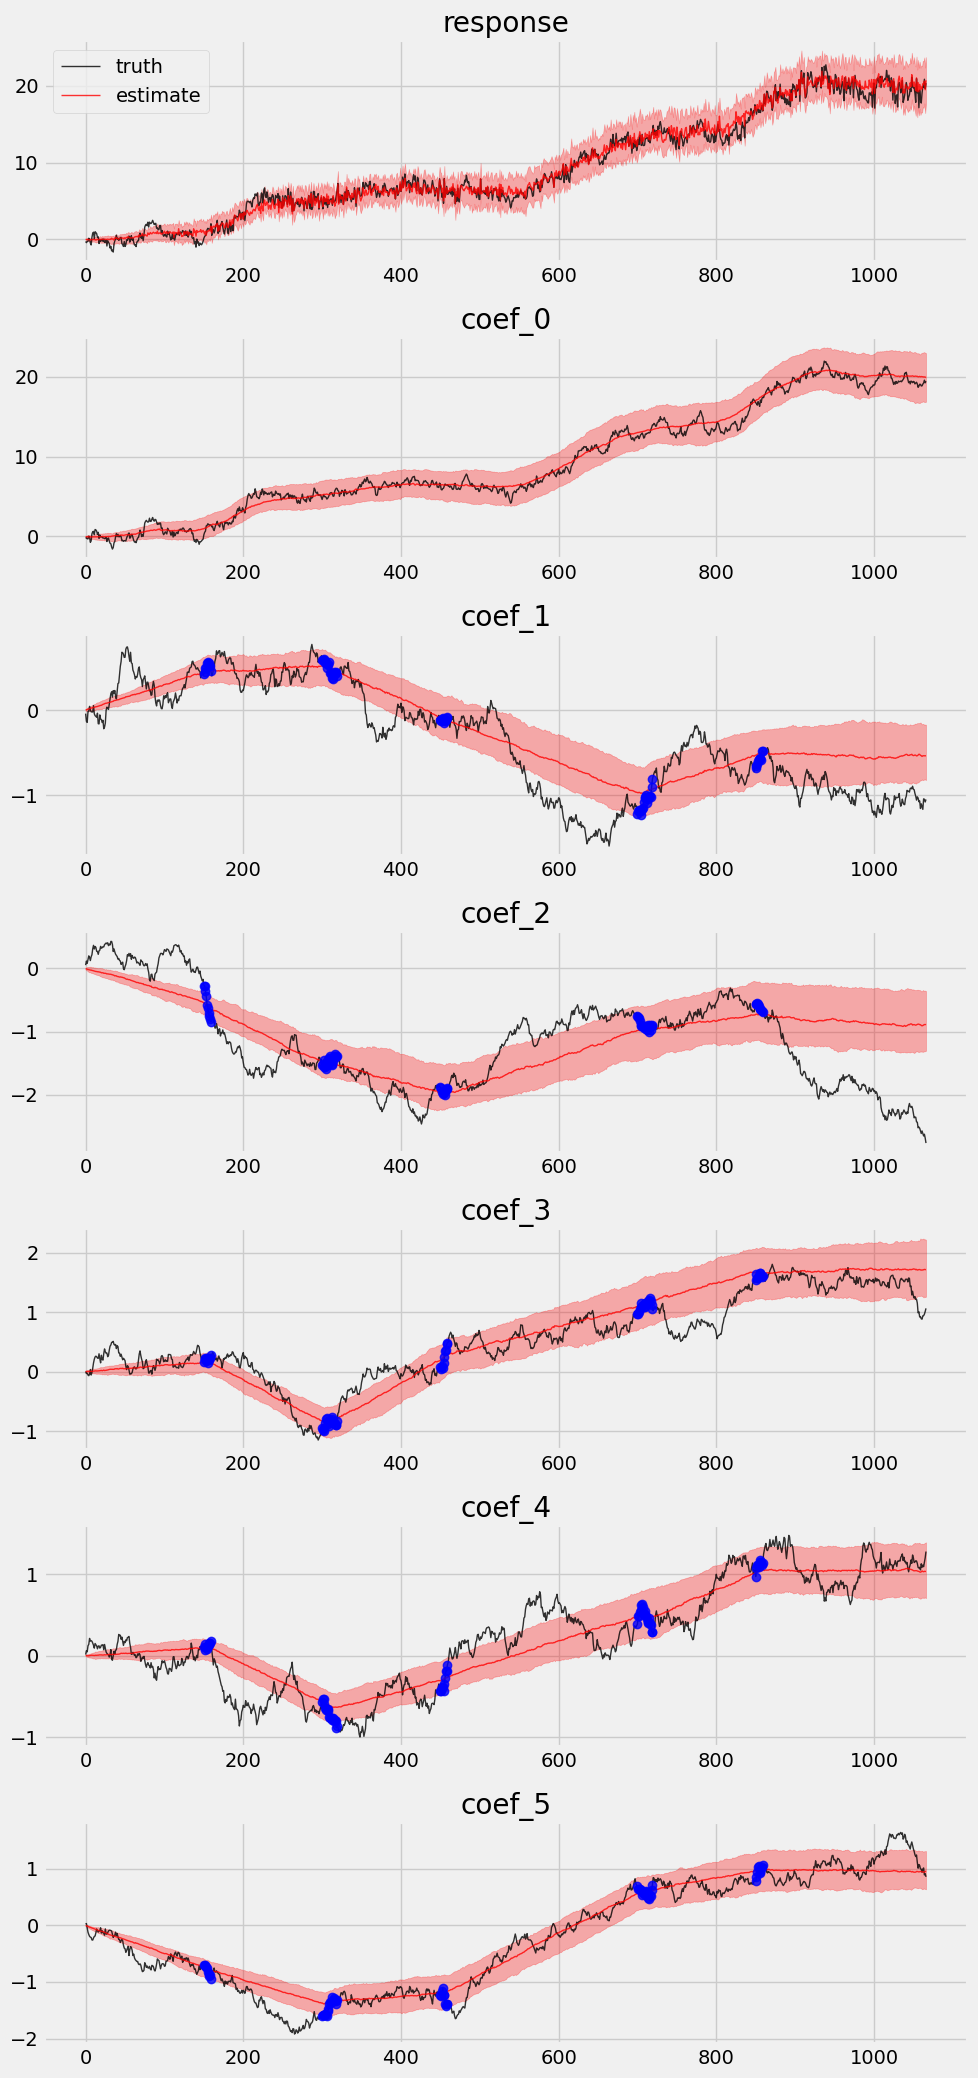

In [16]:
# overlay estimations with truth
fig, axes = plt.subplots(p + 2, 1, figsize=(10, 3 * (p + 2)))
# posterior quantiles of latent variables
pred_p10, pred_p50, pred_p90 = quantile(posterior_samples['prediction'], (0.1, 0.5, 0.9)).squeeze(-1)
# posterior quantiles of latent variables
coef_p10, coef_p50, coef_p90 = quantile(posterior_samples['weight'], (0.1, 0.5, 0.9)).squeeze(-1)

for idx, ax in enumerate(axes):
    if idx == 0:
        axes[0].plot(y[:T1], 'k-', label='truth', alpha=.8, lw=1)
        axes[0].plot(pred_p50, 'r-', label='estimate', alpha=.8, lw=1)
        axes[0].fill_between(torch.arange(0, T1), pred_p10, pred_p90, color="red", alpha=.3)
        axes[0].legend()
        axes[0].set_title('response')
    else:
        axes[idx].plot(betas[:T1, idx -  1], 'k-', label='truth', alpha=.8, lw=1)
        axes[idx].plot(coef_p50[:, idx - 1], 'r-', label='estimate', alpha=.8, lw=1)
        if idx >= 2:
            axes[idx].plot(time_points, priors[:, idx-2], 'o', color='blue', alpha=.8, lw=1)
        axes[idx].fill_between(torch.arange(0, T1), coef_p10[:, idx-1], coef_p90[:, idx-1], color="red", alpha=.3)
        axes[idx].set_title('coef_{}'.format(idx - 1))
plt.tight_layout()

### Holdout validation

torch.Size([1000, 28, 1]) torch.Size([28])


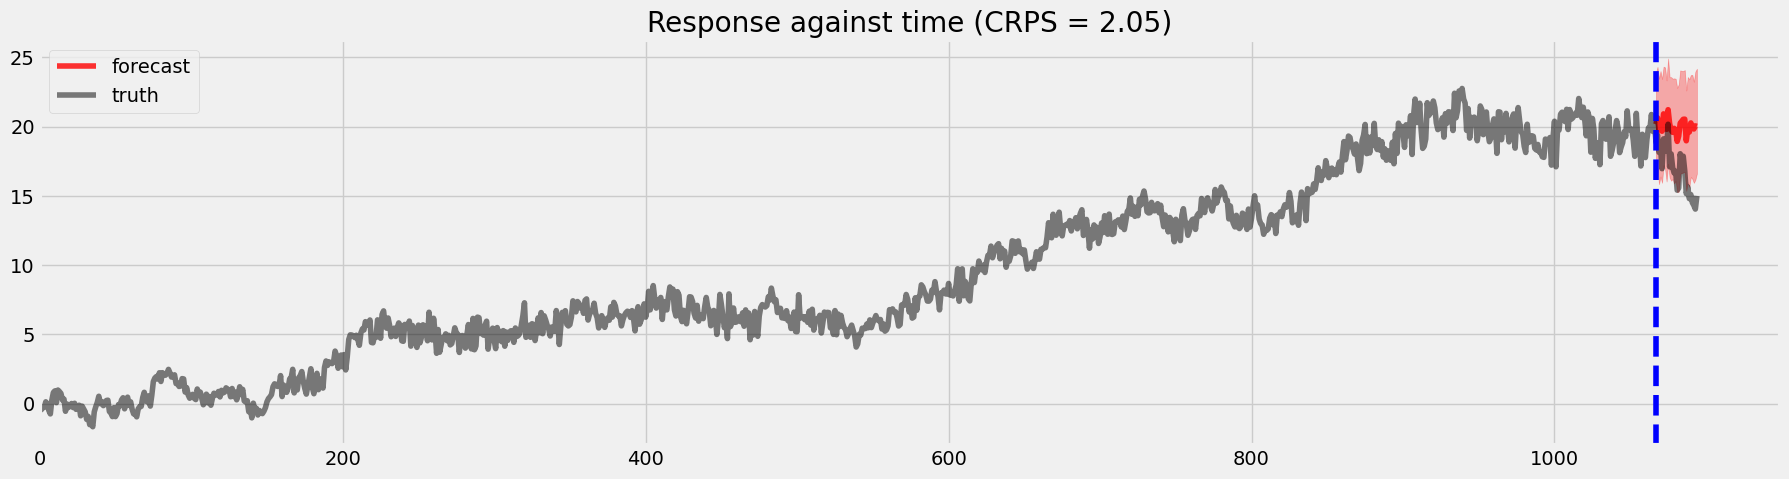

In [17]:
samples = forecaster(y[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, y[T1:])
print(samples.shape, p10.shape)

plt.figure(figsize=(20, 5))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast', alpha=.8)
plt.plot(y, 'k-', label='truth', alpha=.5)
plt.title("Response against time (CRPS = {:0.3g})".format(crps))
plt.xlim(0, None)
plt.axvline(T1, color='b', linestyle='--')
plt.legend(loc="best");

## Conclusion

1. We finish a DLM model in Pyro provides decent forecast with simulated dataset
2. We see a significant improvement on posteriors sampling and out-of-sample prediction CRPS after priors injection.
3. DLM allowing priors injection is practical in modeling business where user can perform experimentations from time to time.

## Reference
- Harvey, C. A. (1989). *Forecasting, Structural Time Series and the Kalman Filter*, Cambridge University Press.
- Durbin, J., Koopman, S. J.. (2001). *Time Series Analysis by State Space Methods*, Oxford Statistical Science Series
- Scott, S. L., and Varian, H. (2015). "Inferring Causal Impact using Bayesian Structural Time-Series Models" The Annals of Applied Statistics, 9(1), 247–274.
- Moore, D., Burnim, J, and the TFP Team (2019). "Structural Time Series modeling in TensorFlow Probability" Available at [https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html](https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html)